In [1]:
from database.market import Market
import pandas as pd
from statistics import variance
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

In [2]:
market = Market()
market.connect()
tickers = market.retrieve_data("sp500")["Symbol"]
market.close()

In [3]:
test = True
if test:
    ticker = "AAPL"
    pdr_data = market.retrieve_price_data("pdr_prices",ticker)
    quandl_data = market.retrieve_price_data("prices",ticker)
    tiingo_data = market.retrieve_price_data("tiingo_prices",ticker)
    pdr_data.index = pd.to_datetime(pdr_data["Date"],utc=True)
    quandl_data.index = pd.to_datetime(quandl_data["Date"],utc=True)
    tiingo_data.index = pd.to_datetime(tiingo_data["date"],utc=True)
    lel = pdr_data.join(tiingo_data,lsuffix="pdr",rsuffix="tiingo")
    final = lel.join(quandl_data,rsuffix="quandl")
    v = []
    for i in range(len(final)):
        row = final.iloc[i]
        var = variance([row["Adj_Close"],row["Adj Close"],row["adjClose"]])
        v.append(var)
    final["var"] = v
    max_var = final["var"].max()
    weird = final[final["var"] == max_var]["date"].item()
    mean_var = final["var"].mean()
    instances = len(final[final["var"] > 0.005])
    record = {"ticker":ticker,"max_v":max_var,"mean_v":mean_var,"instances":instances,"extreme":weird}

In [4]:
records = []
fails = []
for ticker in tqdm(tickers):
    try:
        pdr_data = market.retrieve_price_data("pdr_prices",ticker)
        quandl_data = market.retrieve_price_data("prices",ticker)
        tiingo_data = market.retrieve_price_data("tiingo_prices",ticker)
        pdr_data.index = pd.to_datetime(pdr_data["Date"],utc=True)
        quandl_data.index = pd.to_datetime(quandl_data["Date"],utc=True)
        tiingo_data.index = pd.to_datetime(tiingo_data["date"],utc=True)
        lel = pdr_data.join(tiingo_data,lsuffix="pdr",rsuffix="tiingo")
        final = lel.join(quandl_data,rsuffix="quandl")
        pdr_data = market.retrieve_price_data("pdr_prices",ticker)
        final["date"] = [datetime.strptime(x.split("T")[0],"%Y-%m-%d") for x in final["date"]]
        final = final[final["date"]>datetime(2010,1,1)]
        v = []
        for i in range(len(final)):
            row = final.iloc[i]
            var = variance([row["Adj_Close"],row["Adj Close"],row["adjClose"]])
            v.append(var)
        final["var"] = v
        max_var = final["var"].max()
        weird = final[final["var"] == max_var]["date"].iloc[0]
        mean_var = final["var"].mean()
        instances = len(final[final["var"] > 0.005])
        record = {"ticker":ticker,"max_v":max_var,"mean_v":mean_var,"instances":instances,"extreme":weird}
        records.append(record)
    except Exception as e:
        print(ticker,str(e))
        fails.append({"ticker":ticker,"error":str(e)})

  3%|██▉                                                                                                | 15/505 [01:18<41:04,  5.03s/it]

ALK 'float' object has no attribute 'split'


  5%|████▋                                                                                              | 24/505 [02:04<39:31,  4.93s/it]

GOOG 'float' object has no attribute 'split'


  5%|█████▎                                                                                             | 27/505 [02:19<38:35,  4.84s/it]

AMCR 'float' object has no attribute 'split'


 12%|███████████▉                                                                                       | 61/505 [05:18<37:29,  5.07s/it]

BKR 'float' object has no attribute 'split'


 13%|█████████████▏                                                                                     | 67/505 [05:47<33:23,  4.57s/it]

BRK.B 'Date'


 14%|█████████████▌                                                                                     | 69/505 [05:55<30:48,  4.24s/it]

BIO 'Date'


 16%|███████████████▋                                                                                   | 80/505 [06:51<31:54,  4.50s/it]

BF.B 'Date'


 18%|██████████████████                                                                                 | 92/505 [07:52<33:27,  4.86s/it]

CBRE 'float' object has no attribute 'split'


 30%|█████████████████████████████                                                                     | 150/505 [12:56<30:09,  5.10s/it]

DISH 'float' object has no attribute 'split'


 32%|███████████████████████████████                                                                   | 160/505 [13:48<28:55,  5.03s/it]

DD 'float' object has no attribute 'split'


 32%|███████████████████████████████▏                                                                  | 161/505 [13:53<27:44,  4.84s/it]

DXC 'float' object has no attribute 'split'


 35%|██████████████████████████████████▌                                                               | 178/505 [15:23<27:31,  5.05s/it]

EVRG 'float' object has no attribute 'split'


 55%|█████████████████████████████████████████████████████▌                                            | 276/505 [23:57<19:27,  5.10s/it]

KIM 'float' object has no attribute 'split'


 58%|████████████████████████████████████████████████████████▊                                         | 293/505 [25:26<18:00,  5.09s/it]

LIN 'float' object has no attribute 'split'


 72%|███████████████████████████████████████████████████████████████████████                           | 366/505 [31:48<11:23,  4.91s/it]

PYPL 'float' object has no attribute 'split'


 75%|█████████████████████████████████████████████████████████████████████████▏                        | 377/505 [32:44<09:58,  4.67s/it]

PNC 'Date'


 75%|█████████████████████████████████████████████████████████████████████████▎                        | 378/505 [32:47<08:53,  4.20s/it]

PPG 'Date'


 75%|█████████████████████████████████████████████████████████████████████████▌                        | 379/505 [32:51<08:08,  3.88s/it]

PPL 'Date'


 75%|█████████████████████████████████████████████████████████████████████████▉                        | 381/505 [32:59<08:13,  3.98s/it]

PG 'Date'


 78%|████████████████████████████████████████████████████████████████████████████                      | 392/505 [33:55<08:31,  4.53s/it]

DGX 'Date'


 80%|██████████████████████████████████████████████████████████████████████████████                    | 402/505 [34:47<08:37,  5.03s/it]

RHI 'float' object has no attribute 'split'


 81%|███████████████████████████████████████████████████████████████████████████████▏                  | 408/505 [35:18<08:03,  4.99s/it]

SPGI 'float' object has no attribute 'split'


 83%|█████████████████████████████████████████████████████████████████████████████████▎                | 419/505 [36:14<06:32,  4.57s/it]

SLG 'Date'


 91%|████████████████████████████████████████████████████████████████████████████████████████▉         | 458/505 [39:37<03:51,  4.93s/it]

UA 'float' object has no attribute 'split'


 96%|██████████████████████████████████████████████████████████████████████████████████████████████▌   | 487/505 [42:09<01:30,  5.05s/it]

WELL 'float' object has no attribute 'split'


 98%|████████████████████████████████████████████████████████████████████████████████████████████████  | 495/505 [42:49<00:49,  4.94s/it]

WLTW 'float' object has no attribute 'split'


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████ | 500/505 [43:13<00:22,  4.50s/it]

XYL 'date'


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▏| 501/505 [43:16<00:16,  4.05s/it]

YUM 'date'


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▍| 502/505 [43:20<00:11,  3.82s/it]

ZBRA 'date'


100%|█████████████████████████████████████████████████████████████████████████████████████████████████▌| 503/505 [43:23<00:07,  3.56s/it]

ZBH 'date'


100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 504/505 [43:26<00:03,  3.39s/it]

ZION 'date'


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 505/505 [43:31<00:00,  5.17s/it]


In [5]:
analysis = pd.DataFrame(records)

In [6]:
strange = analysis[analysis["mean_v"] > 1].sort_values("mean_v",ascending=False)

In [7]:
len(strange)

35

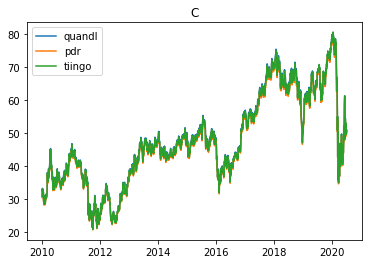

In [8]:
ticker = "C"
pdr_data = market.retrieve_price_data("pdr_prices",ticker)
quandl_data = market.retrieve_price_data("prices",ticker)
tiingo_data = market.retrieve_price_data("tiingo_prices",ticker)
pdr_data.index = pd.to_datetime(pdr_data["Date"],utc=True)
quandl_data.index = pd.to_datetime(quandl_data["Date"],utc=True)
tiingo_data.index = pd.to_datetime(tiingo_data["date"],utc=True)
lel = pdr_data.join(tiingo_data,lsuffix="pdr",rsuffix="tiingo")
final = lel.join(quandl_data,rsuffix="quandl")
final["date"] = [datetime.strptime(x.split("T")[0],"%Y-%m-%d") for x in final["date"]]
final = final[final["date"]>datetime(2010,1,1)]
plt.plot(final["Adj_Close"])
plt.plot(final["Adj Close"])
plt.plot(final["adjClose"])
plt.legend(["quandl","pdr","tiingo"])
plt.title(ticker)
plt.show()

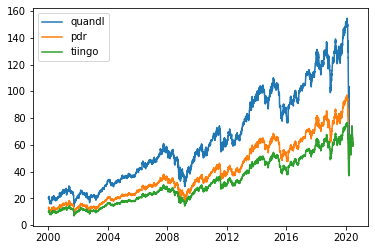

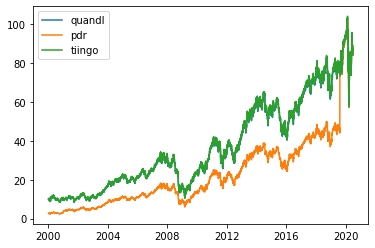

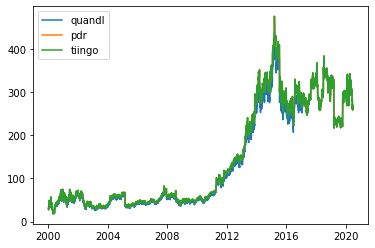

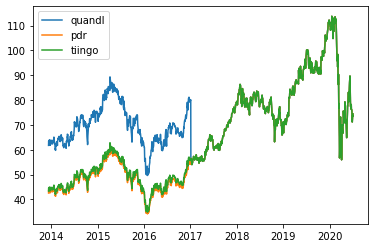

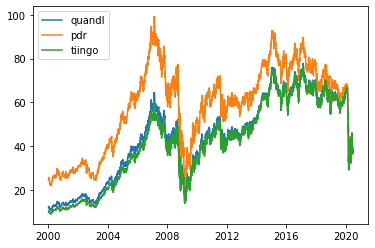

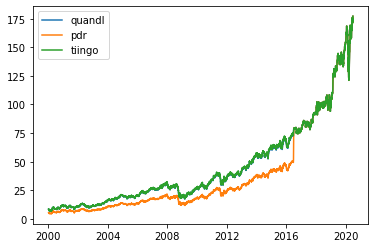

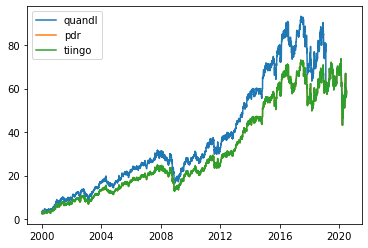

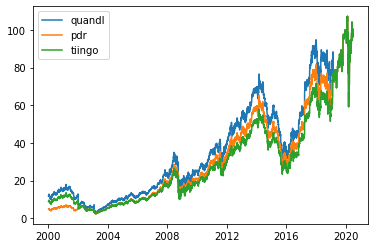

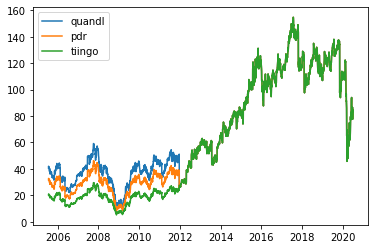

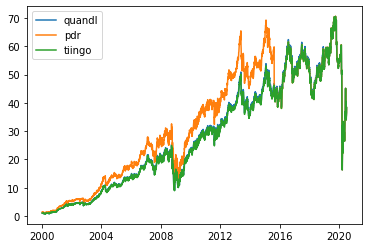

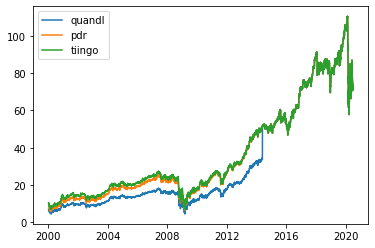

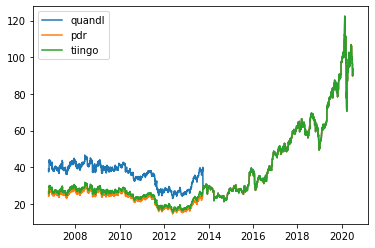

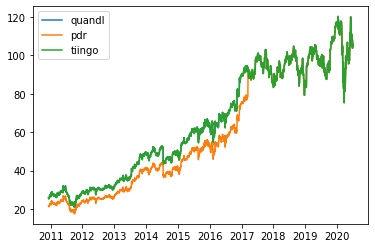

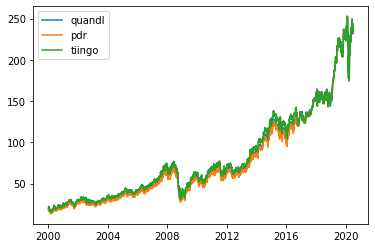

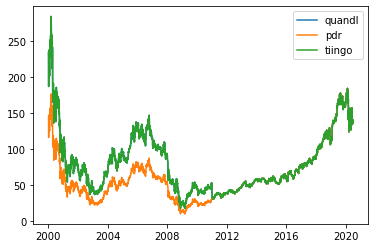

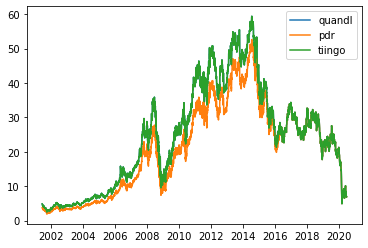

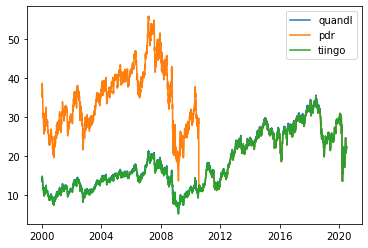

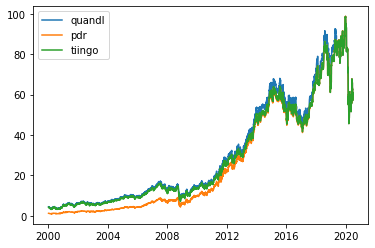

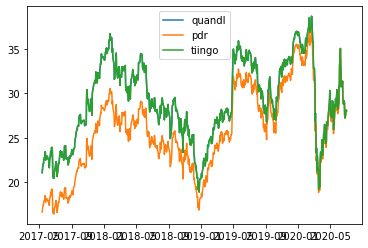

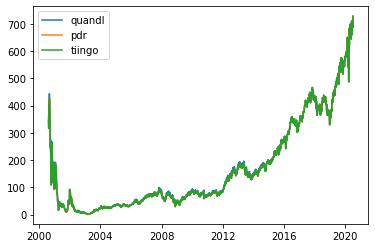

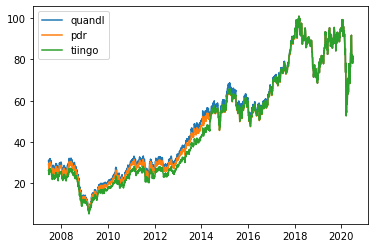

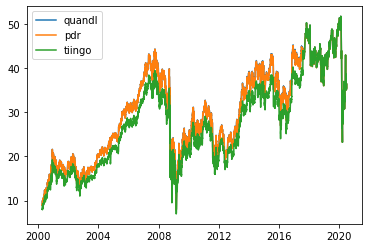

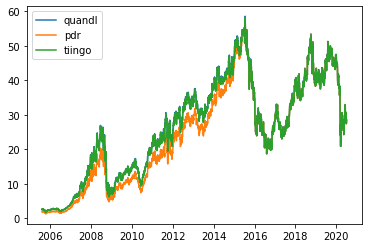

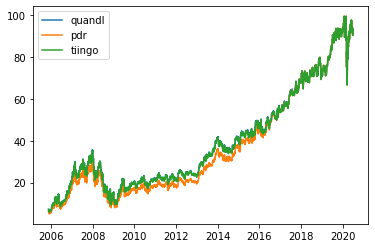

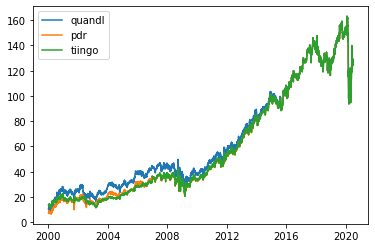

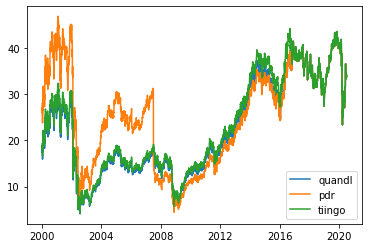

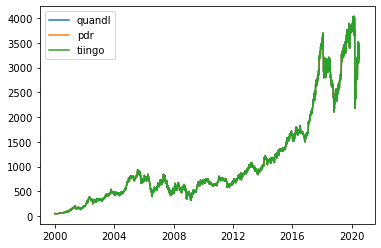

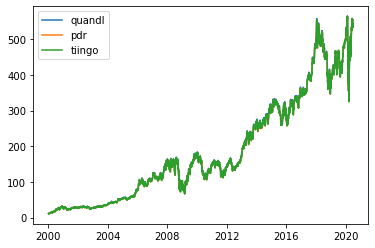

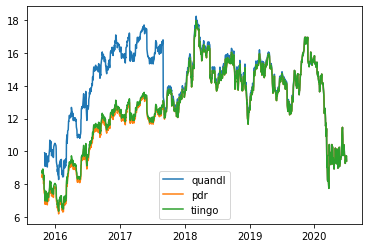

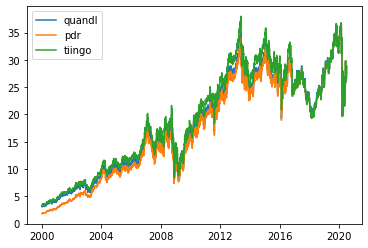

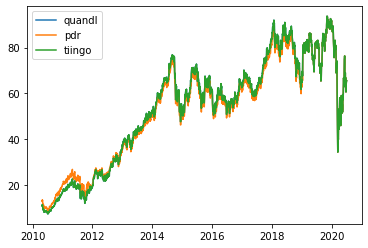

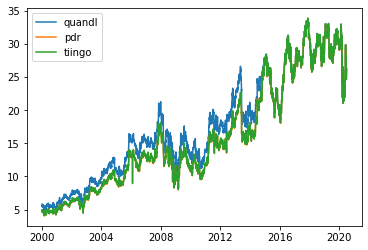

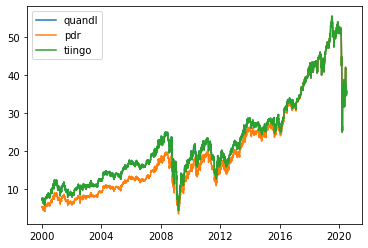

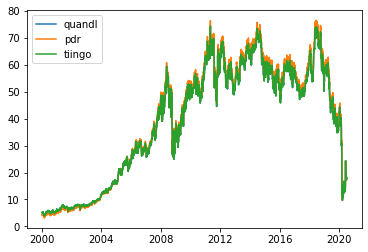

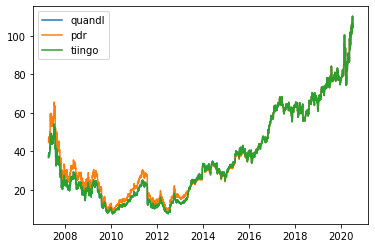

In [9]:
for ticker in strange["ticker"]:
    pdr_data = market.retrieve_price_data("pdr_prices",ticker)
    quandl_data = market.retrieve_price_data("prices",ticker)
    tiingo_data = market.retrieve_price_data("tiingo_prices",ticker)
    pdr_data.index = pd.to_datetime(pdr_data["Date"],utc=True)
    quandl_data.index = pd.to_datetime(quandl_data["Date"],utc=True)
    tiingo_data.index = pd.to_datetime(tiingo_data["date"],utc=True)
    lel = pdr_data.join(tiingo_data,lsuffix="pdr",rsuffix="tiingo")
    final = lel.join(quandl_data,rsuffix="quandl")
    plt.plot(final["Adj_Close"])
    plt.plot(final["Adj Close"])
    plt.plot(final["adjClose"])
    plt.legend(["quandl","pdr","tiingo"])
    plt.show()

In [10]:
final[final["var"] > 0.001][["Adj Close","Adj_Close","adjClose"]]

KeyError: 'var'